In [1]:
import re
import os
import csv
import healpy as hp
import numpy as np
import pandas as pd
from scipy.stats import linregress
from itertools import chain

from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import Normalize

import seaborn as sb
blue=sb.xkcd_palette(['windows blue'])[0]
amber=sb.xkcd_palette(['amber'])[0]
% matplotlib inline

import sys
if sys.platform=='darwin':
    top_path='/Users/codydirks/PGCC/'
else:
    top_path='/DataDisk/datafiles/PGCC_HST/'

x1d_dir=top_path+'x1d_files/'

c=300000.

# Sightline | NH2 | N_Cl | N_O
sheffer_data=[('HD23180',20.61,13.75,17.76),
     ('HD23478',20.57,14.85,17.71),
     ('HD24398',20.67,14.42,17.77),
    ('HD112999',20.11,13.53,17.76),
    ('HD124314',20.52,14.20,18.21),
    ('HD147683',20.74,14.47,17.88)
     ]

# Sightline | N(H I) | N(H2)
jenkins_data=[
    ( 'HD23180',20.88,20.60),
    ( 'HD23478',20.71,20.48),
    ( 'HD24398',20.80,20.67),
    ('HD112999',np.nan,20.11),
    ('HD124314',21.41,20.52),
    ('HD147683',21.20,20.68),
    ('HD148594',np.nan,19.88),
    ('HD185418',21.19,20.71),
    ('HD210839',21.15,20.84),
    ('HD232522',21.08,20.22),
]

# Sightline | CO | 13CO
sheffer_isotope_data=[('HD22951', 1.83e14,2.31e12),
('HD23180', 6.78e14,9.32e12),
('HD23478', 8.05e14,12.0e12),
('HD24398', 17.9e14,16.5e12),
('HD24534', 158e14,186.0e12),
('HD27778', 123e14,183.0e12),
('HD99872', 4.54e14,5.6e12),
('HD147683', 80.3e14,113e12),
('HD148937', 3.81e14,6.6e12),
('HD177989', 4.4e14,8.35e12),
('HD192035', 13.9e14,27.5e12),
('HD198781', 16.6e14,27.7e12),
('HD203374A', 25.5e14,33.3e12),
('HD203532', 45.6e14,111e12),
('HD206267A', 134e14,322e12),
('HD207198', 31.6e14,66.1e12),
('HD207308', 83.2e14,118e12),
('HD207538', 23.4e14,45.6e12),
('HD208266', 116e14,138e12),
('HD210839', 27.5e14,35.4e12)]


class LineInfo(object):
    def __init__(self,dat_line,err_line):
        dat=dat_line.split()
        if len(dat)==10:
            self.ion=dat[0]
            self.n=float(dat[1])
            self.b=float(dat[2])
            self.wav=float(dat[3])
            self.v=float(dat[4])
            self.n_flag=int(dat[5])
            self.b_flag=int(dat[6])
            self.v_flag=int(dat[7])
            self.eqw=float(dat[8])
            self.tot_eqw=float(dat[9])
        elif len(dat)<10:
            self.ion=dat_line[0:10]
            self.n=float(dat_line[10:20])
            self.b=float(dat_line[20:28])
            self.wav=float(dat_line[28:38])
            self.v=float(dat_line[38:48])
            self.n_flag=int(dat_line[48:52])
            self.b_flag=int(dat_line[52:54])
            self.v_flag=int(dat_line[54:56])
            self.eqw=float(dat_line[56:64])
            self.tot_eqw=float(dat_line[64:])
        
        errs=err_line.split()
        self.n_err=float(errs[0])
        self.b_err=float(errs[1])
        self.v_err=float(errs[2])
        
    def __repr__(self):
        return self.ion
    def __str__(self):
        return self.ion

def load_results(filename):
    gaia_filenames=[top_path+'gaia_data/TgasSource_000-000-0'+'{:02}'.format(i)+'.fits' for i in range(16)]
    pgcc_data=fits.open(top_path+'HFI_PCCS_GCC_R2.02.fits')[1].data
    sightline_pgcc_gaia_data=[]
    with open(filename,'r') as myfile:
        for line in myfile:
            dat=line.strip('|\n').split('|')
            sightline=dat[0]
            coords=dat[1].split(' ')
            ra=float(coords[0])*u.degree
            dec=float(coords[1])*u.degree
            pgcc=pgcc_data[int(dat[2])]
            if dat[3] != 'None':
                fl,idx=map(int,dat[3][1:-1].split(','))
                gaia_entry=fits.open(gaia_filenames[fl])[1].data[idx]
            else:
                gaia_entry=None
                
            sightline_pgcc_gaia_data.append([sightline,(ra,dec),pgcc,gaia_entry])
    return sightline_pgcc_gaia_data

# Returns the velocity shift necessary to convert Helio to LSR
# i.e. returns (V_lsr - V_helio)
def HelioToLSR(target_ra_deg, target_dec_deg):
    Vsun=19.7
    a0=271.0*np.pi/180.
    d0=30.0*np.pi/180.
    a=target_ra_deg*np.pi/180.
    d=target_dec_deg*np.pi/180.
    #shift=Vsun*(np.cos(a-a0)*np.cos(a0)*np.cos(a)+np.sin(d0)*np.sin(d))
    shift=Vsun*(np.cos(a0)*np.cos(d0)*np.cos(a)*np.cos(d)
                +np.sin(a0)*np.cos(d0)*np.sin(a)*np.cos(d)
                +np.sin(d0)*np.sin(d))
    return shift


def get_r_dist(pgcc,sightline_ra,sightline_dec):
    angle=pgcc['gau_position_angle']
    sin=np.sin(-angle)
    cos=np.cos(-angle)
    a=pgcc['gau_major_axis']/2.
    b=pgcc['gau_minor_axis']/2.
    gal=SkyCoord(ra=sightline_ra*u.degree,dec=sightline_dec*u.degree,frame='icrs').galactic
    del_l=60.*(gal.l.value-pgcc['glon'])
    del_b=60.*(gal.b.value-pgcc['glat'])
    return np.sqrt((((cos*del_l+sin*del_b)/a)**2+((sin*del_l-cos*del_b)/b)**2))


def get_cfa_vels_spec(data,hdr,glon,glat):
    cfa_vels=hdr['CRVAL1']+hdr['CDELT1']*np.arange(hdr['NAXIS1'])
    cfa_glons=hdr['CRVAL2']+hdr['CDELT2']*np.arange(hdr['NAXIS2'])
    cfa_glats=hdr['CRVAL3']+hdr['CDELT3']*np.arange(-hdr['NAXIS3']/2+1,hdr['NAXIS3']/2+1)
    
    if glon > 180:
        glon=glon-360
    glon_idx=min(range(len(cfa_glons)),key=lambda i: abs(cfa_glons[i]-glon))
    glat_idx=min(range(len(cfa_glats)),key=lambda i: abs(cfa_glats[i]-glat))
    cfa_spec=data[glat_idx,glon_idx,:]
    return cfa_vels,cfa_spec
    
    
def get_co_map(data,hdr,glon,glat,box,vel=0,vel_width=20):
    cfa_vels=hdr['CRVAL1']+hdr['CDELT1']*np.arange(hdr['NAXIS1'])
    cfa_glons=hdr['CRVAL2']+hdr['CDELT2']*np.arange(hdr['NAXIS2'])
    cfa_glats=hdr['CRVAL3']+hdr['CDELT3']*np.arange(-hdr['NAXIS3']/2+1,hdr['NAXIS3']/2+1)
    
    if glon > 180:
        glon=glon-360

    min_vel=vel-vel_width
    max_vel=vel+vel_width
    min_vel_idx=min(range(len(cfa_vels)), key=lambda i: abs(cfa_vels[i]-min_vel))
    max_vel_idx=min(range(len(cfa_vels)), key=lambda i: abs(cfa_vels[i]-max_vel))

    # Isolate a box around the sightline
    box=2.0
    glon_idx=min(range(len(cfa_glons)),key=lambda i: abs(cfa_glons[i]-glon))
    glat_idx=min(range(len(cfa_glats)),key=lambda i: abs(cfa_glats[i]-glat))
    min_glon=min(range(len(cfa_glons)),key=lambda i: abs(cfa_glons[i]-(glon+box/2.)))
    max_glon=min(range(len(cfa_glons)),key=lambda i: abs(cfa_glons[i]-(glon-box/2.)))
    min_glat=min(range(len(cfa_glats)),key=lambda i: abs(cfa_glats[i]-(glat-box/2.)))
    max_glat=min(range(len(cfa_glats)),key=lambda i: abs(cfa_glats[i]-(glat+box/2.)))
    #print cfa_data[min_vel_idx:max_vel_idx,min_glon:max_glon,min_glat:max_glat]
    cube=data[min_glat:max_glat,min_glon:max_glon,min_vel_idx:max_vel_idx]
    cube[np.isnan(cube)]=0
    dat=np.sum(cube,axis=2)
    #if cfa_glons[min_glon] < 0:
    #    return dat[::-1,:],[cfa_glons[min_glon]+360,cfa_glons[max_glon]+360,cfa_glats[min_glat],cfa_glats[max_glat]]
    #else:
    #return dat[::-1,:],[cfa_glons[min_glon],cfa_glons[max_glon],cfa_glats[min_glat],cfa_glats[max_glat]]
    return dat[::-1,:],[1.1,-1.1,-1.1,1.1]



def parse_results_file(filename):
    ids=['O_I]','Cl_I','C_I','C_I*','C_I**','CO','13CO','Ni_II','Kr_I','Ge_II','Mg_II']
    ions=[]
    with open(filename) as myfile:
        lines=[x.strip() for x in myfile.readlines()]
        for i in range(len(lines)):
            if len(lines[i].strip())>0:
                dat=lines[i].split()
                if any([dat[0]==x for x in ids]) or dat[0].startswith('CO_'):
                    ions.append(LineInfo(lines[i],lines[i+1]))
    return ions

def get_sightline_fits6p_results(sightline, ion):
    del_v_tol=1.5
    data=[]
    fits6p_prefix=get_fits6p_ion(ion)
    for fl in [x for x in os.listdir(x1d_dir+sightline+'/E140H') if x.startswith(fits6p_prefix) and x.endswith('.txt')]:
        ions=parse_results_file(x1d_dir+sightline+'/E140H/'+fl)
        if 'CO' in ion:
            selected_ions=[i for i in ions if i.ion.startswith(ion)]
        else:
            selected_ions=[i for i in ions if i.ion==ion]
        data.append((fl,selected_ions))
    return data


def get_fits6p_ion(strng):
    return strng.strip('*').replace('_','').lower().replace('i','I').replace('nI','ni').strip(']')

def get_table_ion(strng):
    return strng.replace('_I]','').replace('_II','').replace('_I','')



def get_atomic_entry(wav):
    if wav==1328.833:
        wav=1328.8333
    with open('/Users/codydirks/fits6p/atomic.dat','r') as myfile:
        lines=myfile.read().split('\n')[1:]
    for line in lines:
        if float(line.split()[0])==wav:
            return float(line[30:39])

def get_ul(sl,line):
    f=get_atomic_entry(line)
    fil=x1d_dir+sl+'/E140H/'+sl+'_'+str(line)+'.dat'
    wavs=[]
    flxs=[]
    with open(fil,'r') as myfile:
        for entry in myfile:
            wav,flx=entry.split()[:2]
            wavs.append(float(wav))
            flxs.append(float(flx))
            
    wavs=np.array(wavs)
    flxs=np.array(flxs)
    flxcut=np.copy(flxs)
    n=0
    ind=np.array([])
    while abs(np.mean(flxcut)-1)>0.002:
        n=n+1
        ind = np.argpartition(abs(flxs-np.mean(flxcut)), -n)[-n:]
        flxcut=np.delete(flxs,ind)
    tau=np.log10(1/(1-5.*np.std(flxcut)))
    ul=3.768E14*tau/(f*line)
    return np.log10(ul)

In [2]:
with open('primary_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    primary_sightlines=inp.next()
    primary_sightlines.append('HD203532')
    
with open('secondary_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    secondary_sightlines=inp.next()
    
with open('in_front_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    in_front_sightlines=inp.next()


In [3]:
with open('primary_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    primary_sightlines=inp.next()
    
filename='sightline_pgcc_gaia_results.txt'
all_data=load_results(filename)
all_data.sort(key=lambda x: (x[0][0],int(re.search(r'\d+',x[0]).group())))

primary_sample=[x for x in all_data if x[0] in primary_sightlines]
len(primary_sample)

22

In [4]:
sheffer_data=pd.read_csv('sheffer_co_h2.csv')
burgh_data=pd.read_csv('burghtable2.csv')

In [16]:
del_v_tol=1.5
ion_list=['O_I]','Cl_I','C_I','C_I*','C_I**','CO','13CO','Ni_II','Kr_I','Ge_II','Mg_II']
ns_dict={}
info={'Sightline':[],'R_dist':[],'Velocity':[]}
for ion in ion_list:
    ns_dict[ion]=0
    
    info[get_table_ion(ion)]=[]
    info[get_table_ion(ion)+'_err']=[]
    
all_data=pd.DataFrame(info)

for sl in primary_sample:
    info['Sightline']=sl[0]
    ra,dec=sl[1]
    galcoords=SkyCoord(ra=ra,dec=dec).galactic
    pgcc=sl[2]
    info['R_dist']=round(get_r_dist(pgcc,ra.value,dec.value),2)
    
    data_dict={}
    for ion in ion_list:
        data_dict[ion]=get_sightline_fits6p_results(info['Sightline'],ion)
    
    vel_comps=[]
    [vel_comps.append(v) for v in [y.v for y in chain(*[x[1] for x in (data_dict['CO']+data_dict['13CO']+data_dict['O_I]']+data_dict['Cl_I'])])]
     if any([abs(v-z)<del_v_tol for z in vel_comps])==False]
        
    vel_comps.sort()
    for v in vel_comps:
        n_dict={}
        comps_dict={}
        # Initialize components and columns to zero
        for ion in ion_list:
            n_dict[ion]=0
            n_dict[ion+'_err']=0
            comps_dict={}
        
        # Iterate over ions and get nearest component, then add columns in that component
        for ion in ion_list:
            for entry in data_dict[ion]:
                comps_dict[ion]=[c for c in entry[1] if abs(c.v-v)<del_v_tol]
                if len(comps_dict[ion])>0:
                    n_tot=sum([x.n for x in comps_dict[ion]])
                    n_err=np.sqrt(sum([x.n_err*x.n_err for x in comps_dict[ion]]))
                    n_dict[ion]=round(np.log10(n_tot),3)
                    #n_dict[ion+'_err']=0.434*n_err/n_tot
                    n_dict[ion+'_err']=round(np.log10(n_err),3)
                    break
                else:
                    fits6p_prefix=get_fits6p_ion(ion)
                    for fl in [x for x in os.listdir(x1d_dir+sl[0]+'/E140H') if x.startswith(fits6p_prefix) and x.endswith('.txt')]:
                        lam=fl.split('_')[1]
                        dat_file=[x for x in os.listdir(x1d_dir+sl[0]+'/E140H') if x.startswith(sl[0]) and x.endswith('.dat') and lam in x][0]
                        lin=dat_file.split('_')[1][:-4]
                        n_dict[ion+'_err']=get_ul(sl[0],float(lin))
                    break
                    
            info[get_table_ion(ion)]=n_dict[ion]
            info[get_table_ion(ion)+'_err']=n_dict[ion+'_err']
        info['Velocity']=v
        new_row=pd.DataFrame({key:[info[key]] for key in info})
        all_data=pd.concat([all_data,new_row])

cols=['Sightline','R_dist','Velocity']+list(chain.from_iterable([[get_table_ion(i),get_table_ion(i)+'_err'] for i in ion_list]))
all_data=all_data[cols].reset_index(drop=True)
all_data=all_data.replace(-np.inf,0)

/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log10
/Users/codydirks/anaconda2/envs/astroconda/lib/python2.7/site-packages/ipykernel_launcher.py:163: RuntimeWarning: divide by zero encountered in double_scalars


In [17]:
all_data['H_tot']=np.where(all_data['O']>0,np.log10((10**6/305.)*10**(all_data['O'])),0).round(3)
all_data['H_2']=np.where(all_data['Cl']>0, ((all_data['Cl']+3.7)/0.87),0.).round(3)
all_data['f_H2']=np.where((all_data['H_tot']>0) & (all_data['H_2']>0),10**(np.log10(2.)+all_data['H_2']-all_data['H_tot']),0.0).round(3)
all_data['CO/H2']=np.where((all_data['H_2']>0) & (all_data['CO']>0),10**(all_data['CO']-all_data['H_2']),0.0)
all_data['12CO/13CO']=np.where((all_data['13CO']>0) & (all_data['CO']>0),10**(all_data['CO']-all_data['13CO']),0.0).round(3)

In [ ]:
# CO-to-H2 plot
fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)
cm = plt.cm.get_cmap('viridis_r')

s1=[]
s2=[]

nco_min=12
nco_max=17
ncl_min=13.5 # Below this, Balashev conversion to H2 becomes extremely uncertain
#cut=all_data.loc[(all_data['Cl_I']>ncl_min) & (all_data['13CO']>12)]
cut=all_data[(all_data['CO']>13)&(all_data['R_dist']<20)&(all_data['Cl']>13.5)]
norm=Normalize(vmin=0,vmax=10)
for sl in cut.groupby('Sightline'):
    row=sl[1].sort_values('CO',ascending=False).iloc[0]
    print row['f_H2']
    x=row['H_2']
    y=row['CO']
    s1.append(10**(row['CO']-row['H_2']))
    col=cm(norm(row['R_dist']))
    subplt.plot(x,y,marker='o',color=col,markersize=20)
    subplt.text(x,y,row['Sightline'])
print
for idx,row in sheffer_data.iterrows():
    subplt.plot(row['H2'],row['CO'],'ko',markersize=10)
    s2.append(10**(row['CO']-row['H2']))
    
print np.mean(s1)
print np.mean(s2)

In [ ]:
# 12CO/13CO Plots
# Filter results 
nco_min=12
nco_max=17
ncl_min=11 # Below this, Balashev conversion to H2 becomes extremely uncertain
#cut=all_data.loc[(all_data['Cl_I']>ncl_min) & (all_data['13CO']>12)]
cut=all_data.loc[(all_data['12CO/13CO']>0)&(all_data['12CO/13CO']<100)&(all_data['13CO']>13)]



fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)
cm = plt.cm.get_cmap('viridis')
subplt.scatter(cut['CO'],cut['13CO'],marker='o',color=blue,s=100)

x2=[]
y2=[]
for entry in sheffer_isotope_data:
    if entry[0] not in cut['Sightline'].values:
        x2.append(np.log10(entry[1]))
        y2.append(np.log10(entry[2]))
subplt.scatter(x2,y2,marker='o',color=amber,s=100)

tx=np.arange(14,17,0.5)
ty=np.array([np.log10((10**x)/70) for x in tx])
subplt.plot(tx,ty,'k--')

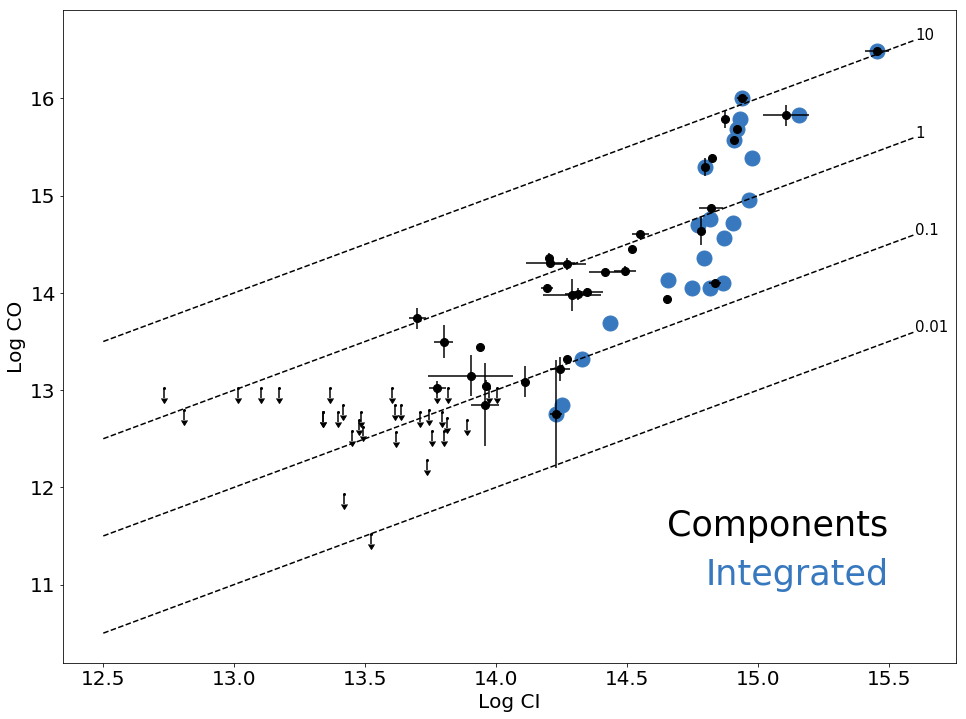

In [26]:
fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)

cut_data=all_data[(all_data['C']>0)]
for sl,data in cut_data.groupby('Sightline'):
    cs_to_sum=all_data[all_data['Sightline']==sl]
    cs=[np.log10(np.sum([10**row[col] for col in ('C','C*','C**')])) for idx,row in cs_to_sum.iterrows()]
    c_errs=list(chain.from_iterable([list(row) for idx,row in cs_to_sum[['C_err','C*_err','C**_err']].iterrows()]))
    c_sum=np.log10(np.sum([10**n for n in cs]))
    c_sum_err=0.434*np.sqrt(np.sum([10**(2*n) for n in c_errs]))/(10**c_sum)
    
    cos_to_sum=all_data[all_data['Sightline']==sl]
    co_sum=np.log10(np.sum([10**n for n in cos_to_sum['CO']]))
    co_sum_err=0.434*np.sqrt(np.sum([10**(2*n) for n in cos_to_sum['CO_err']]))/(10**(co_sum))
    subplt.plot(c_sum,co_sum,marker='o',color=blue,markersize=15,zorder=-1)
    
    num_c_comps=len(all_data[(all_data['Sightline']==sl)&(all_data['C']>0)])
    for idx,row in data.iterrows():
        c=np.log10(np.sum([10**row[col] for col in ('C','C*','C**')]))
        c_err=0.434*np.sum([10**row[col+'_err'] for col in ('C','C*','C**')])/10**c
        if row['CO']<10:
            subplt.errorbar(row['C'],row['CO_err'],
                            yerr=0.1, uplims=True,color='k',marker='o',markersize=2)
        else:
            co_err=0.434*(10**(row['CO_err']-row['CO']))
            subplt.errorbar(c,row['CO'],xerr=c_err,yerr=co_err,marker='o',color='k',markersize=8)
        #subplt.text(c, row['CO'], sl+' '+str(row['Velocity']))
        #print '\t',10**(row['CO']-c_tot)
    
    
tx=np.arange(12.5,15.7,0.1)
for rat in (0.01,0.1,1,10):
    ty=np.array([np.log10(rat*(10**x)) for x in tx])
    subplt.plot(tx,ty,'k--')
    subplt.text(tx[-1],ty[-1],str(rat),fontsize=15)
subplt.set_ylabel('Log CO',fontsize=20)
subplt.set_xlabel('Log CI',fontsize=20)
subplt.tick_params(axis='both', which='major', labelsize=20)

subplt.text(15.5,11.5,'Components',color='k',fontsize=35,horizontalalignment='right')
subplt.text(15.5,11,'Integrated',color=blue,fontsize=35,horizontalalignment='right')

plt.savefig('/Users/codydirks/Desktop/components_vs_integrated.pdf')

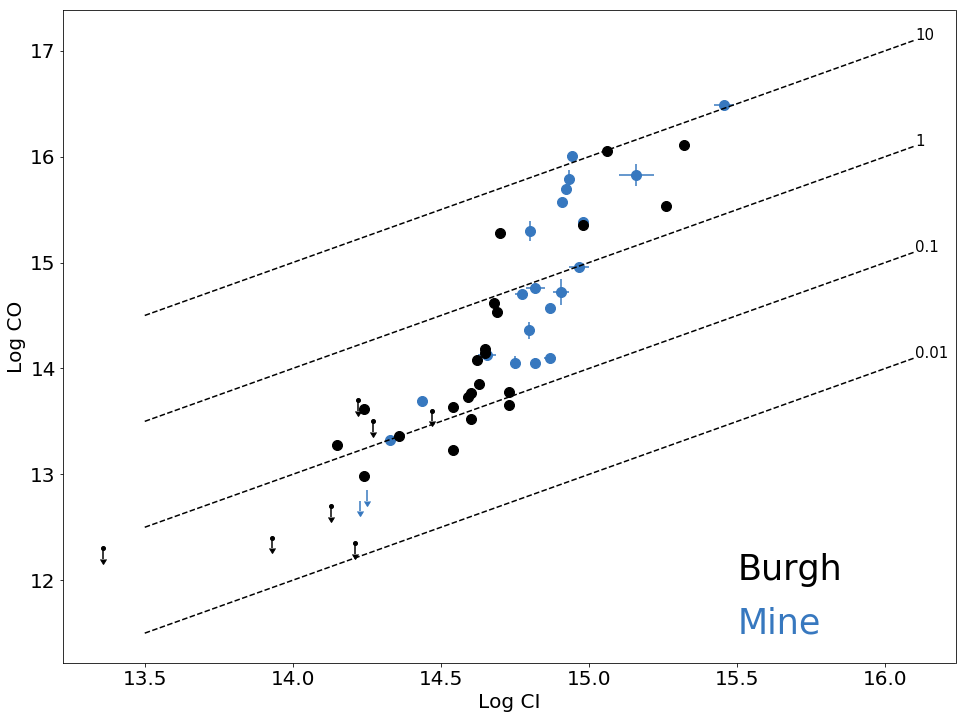

In [28]:
fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)

cut_data=all_data[(all_data['C']>0)]
for sl,data in cut_data.groupby('Sightline'):
    cs_to_sum=all_data[all_data['Sightline']==sl]
    cs=[np.log10(np.sum([10**row[col] for col in ('C','C*','C**')])) for idx,row in cs_to_sum.iterrows()]
    c_errs=list(chain.from_iterable([list(row) for idx,row in cs_to_sum[['C_err','C*_err','C**_err']].iterrows()]))
    c_sum=np.log10(np.sum([10**n for n in cs]))
    c_sum_err=0.434*np.sqrt(np.sum([10**(2*n) for n in c_errs]))/(10**c_sum)
    
    cos_to_sum=all_data[all_data['Sightline']==sl]
    co_sum=np.log10(np.sum([10**n for n in cos_to_sum['CO']]))
    #print cos_to_sum[['Velocity','CO','CO_err','C']]
    co_sum_err=0.434*np.sqrt(np.sum([10**(2*n) for n in cos_to_sum['CO_err']]))/(10**(co_sum))
    if co_sum_err>0.2:
        subplt.errorbar(c_sum,co_sum,yerr=0.1,uplims=True,color=blue,markersize=15,zorder=-1)
    else:
        subplt.errorbar(c_sum,co_sum,xerr=c_sum_err,yerr=co_sum_err,marker='o',color=blue,markersize=10,zorder=-1)
    

for idx,row in burgh_data.iterrows():
    if row['Sightline'] not in all_data['Sightline'].unique():
    # TODO: Add in upper limits
        if row['CO'].startswith('<'):
            co=float(row['CO'][1:])
            cI=float(row['CI'])
            subplt.errorbar(cI,co,yerr=0.1, uplims=True,color='k',marker='o',markersize=4)
        else:
            subplt.plot(float(row['CI']),float(row['CO']),marker='o',color='k',markersize=10)

    
tx=np.arange(13.5,16.1,0.1)
for rat in (0.01,0.1,1,10):
    ty=np.array([np.log10(rat*(10**x)) for x in tx])
    subplt.plot(tx,ty,'k--')
    subplt.text(tx[-1],ty[-1],str(rat),fontsize=15)
subplt.set_ylabel('Log CO',fontsize=20)
subplt.set_xlabel('Log CI',fontsize=20)
subplt.tick_params(axis='both', which='major', labelsize=20)

subplt.text(15.5,12,'Burgh',color='k',fontsize=35)
subplt.text(15.5,11.5,'Mine',color=blue,fontsize=35)

plt.savefig('/Users/codydirks/Desktop/burgh_vs_mine.pdf')

In [ ]:
fig=plt.figure(1,figsize=(16,12))

subplt=plt.subplot(111)

cut_data=all_data[(all_data['C']>0) & (all_data['CO']>12) & (all_data['H_2']>0)]
for sl,data in cut_data.groupby('Sightline'):
    num_c_comps=len(all_data[(all_data['Sightline']==sl)&(all_data['C']>0)])
    for idx,row in data.iterrows():
        c=np.log10(np.sum([10**row[col] for col in ('C','C*','C**')]))
        if row['CO_err']/0.434>1:
            subplt.errorbar(c-row['H_2'],np.log10(row['CO_err']/0.434*10**(row['CO']))-row['H_2'],
                            yerr=0.1, uplims=True,color='k',marker='o',markersize=4)
        else:
            subplt.plot(10**(row['CO']-row['H_2']),10**(row['CO']-c),marker='o',color='k',markersize=50*(row['f_H2']))
            
    to_sum=all_data[all_data['Sightline']==sl]
    cs=[np.log10(np.sum([10**row[col] for col in ('C','C*','C**')])) for idx,row in to_sum.iterrows()]
    c_tot=np.log10(np.sum([10**n for n in cs]))
    
    co_tot=np.log10(np.sum([10**n for n in to_sum['CO']]))
    
    h2_tot=np.log10(np.sum([10**n for n in to_sum['H_2']]))
    #subplt.plot(10**(co_tot-h2_tot),10**(co_tot-c_tot),'ko',markersize=10)


subplt.set_yscale('log')
subplt.set_xscale('log')
#subplt.set_ylim(0.007,100)
#subplt.set_xlim(1e-8,1e-4)
subplt.axvline(1e-6,0,1,color='k',linestyle='--')
subplt.axhline(1.0,0,1,color='k',linestyle='--')

subplt.set_xlabel('CO/H$_2$',fontsize=25)
subplt.set_ylabel('CO/C',fontsize=25)
subplt.tick_params(axis='both', which='major', labelsize=20)

#plt.savefig('/Users/codydirks/Desktop/co_c_h2_ratios_integrated.pdf')

In [ ]:
fig=plt.figure(1,figsize=(16,12))
subplt=plt.subplot(111)
subplt.set_ylim(13.5,16.5)
subplt.set_xlim(13,16)

burgh_data=pd.read_csv('burghtable2.csv')
for idx, burgh_row in burgh_data.iterrows():
    if burgh_row['Sightline'] in all_data['Sightline'].unique():
        cs_to_sum=all_data[all_data['Sightline']==burgh_row['Sightline']]
        cs=[np.log10(np.sum([10**row[col] for col in ('C','C*','C**')])) for idx,row in cs_to_sum.iterrows()]
        c_tot=np.log10(np.sum([10**n for n in cs]))
        
        cos_to_sum=all_data[all_data['Sightline']==burgh_row['Sightline']]
        co_tot=np.log10(np.sum([10**n for n in cos_to_sum['CO']]))
        
        subplt.plot([float(burgh_row['CI']),c_tot],[float(burgh_row['CO']),co_tot],marker='o')
        subplt.text(float(burgh_row['CI']),float(burgh_row['CO']),burgh_row['Sightline'])
        print float(burgh_row['CO'])-co_tot